# Dependencies

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px

from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import Experiment
from cadCAD.engine import ExecutionContext, Executor

# State variables:
* number of users
* THC demand
* THC supply
* THG demand
* THG supply

In [2]:
initial_state={
    'num_users' : 0,
    'THC_demand' : 0,
    'THC_supply' : 0,
    'THG_demand' : 0,
    'THG_supply' : 0
}

# Parameters
* input rate
* investor rate (percentage of investors among the users)
* Player rate (percentage of Players among the users)
* THC deflation rate, which is zero here
* THC upgrade price, which is the average price for upgrading a hero
* THG release amount, which is constant and exogenous to the players and system.

In [3]:
system_params = {
    'input_rate': [1000],
    'investor_rate': [0.2 , 0.25],
    'player_rate': [0.3],
    'THC_deflation': [0],
    'THG_TX_fees': [0.04],
    'THG_upgrade_price': [4],
    'THG_release_amount': [530000]
}

# Policy functions
Policy functions are the imputs to the state update functions. These are the main variables that affect the state variables of the system.

In [4]:
def p_input_users(params,
                  substep,
                  state_history,
                  previous_state):
    #parameters
    rate = params['input_rate']
    
    #logic
    input_people = np.random.poisson(rate , 1)[0]
    
    #output
    return {'add_num_users': input_people}
    

In [5]:
def p_buy_hero(params,
               substep,
               state_history,
               previous_state):
    # parameters and variables
    num_users = previous_state['num_users']
    investor_rate = params['investor_rate']
    player_rate = params['player_rate']
    
    # logic
    n_investors = int(round((num_users* investor_rate),0))
    n_players = int(round((num_users* player_rate),0))
    
    # investors buy hero once every 10 days and players buy once every 20 days
    n_buyers = int(round((n_investors*0.1 + n_players*0.05),0))
    
    # the price of the hero will come from a exponential distribution of the heroes who are currently in the market
    price_vector = np.random.exponential(304.4 , n_buyers)
    agg_demand = np.sum(price_vector)
    
    # output
    return {'add_THC_demand' : agg_demand}
    

In [6]:
def p_THC_supply(params,
                 substep,
                 state_history,
                 previous_state):
    # parameters and variables
    num_users = previous_state['num_users']
    investor_rate = params['investor_rate']
    player_rate = params['player_rate']
    
    # logic
    n_investors = int(round((num_users* investor_rate),0))
    n_players = int(round((num_users* player_rate),0))
    n_earners = num_users - (n_investors + n_players)
    # we assume that at each step 60% of players, 40% of earners and 20% of investors play
    n_active_players = int(round((n_investors*0.5 + n_players*0.7 + n_earners*0.6),0))
    
    # We assume the average daily battles is 14 for each player. It is just a lucky guess
    n_games_daily = int(round((n_active_players/12),0)) * 14
    
    # token issued each game as rewards (20) and the average bonus token issued (5)
    token_issued_daily = n_games_daily * (20+5)
    
    #output
    return {'add_THC_supply' : token_issued_daily}
    

In [7]:
def p_THG_fees(params,
               substep,
               state_history,
               previous_state):
    # parameters and variables'
    # THC_price/THG_price = 0.05
    fee_rate = params['THG_TX_fees'] * 0.05
    THC_supply = previous_state['THC_supply']
    THC_demand = previous_state['THC_demand']
    
    # logic
    fee_payed = max((THC_supply - THC_demand)*fee_rate*0.7 , 0)
    
    # output
    return{'add_THG_demand' : fee_payed}
    

In [8]:
def p_THG_upgrade(params,
                 substep,
                 state_history,
                 previous_state):
    # parameters and variable
    num_users = previous_state['num_users']
    investor_rate = params['investor_rate']
    player_rate = params['player_rate']
    upgrade_fee = params['THG_upgrade_price']
    
    # logic
    n_investors = int(round((num_users* investor_rate),0))
    n_players = int(round((num_users* player_rate),0))
    n_earners = num_users - (n_investors + n_players)
    
    # We assume that players upgrade with probability %30, investors with 10% and earners zero.
    n_players_upgraded = int(round((n_investors*0.1 + n_players*0.3),0))
    
    # We assume that average upgrade fee is 4 gTHG 
    upgrade_fees = n_players_upgraded * upgrade_fee
    
    # output
    return{'add_THG_demand' : upgrade_fees}
    
    

In [9]:
def p_THG_supply(params,
                 substep,
                 state_history,
                 previous_state):
    # params and variables
    THG_amount = params['THG_release_amount']
    
    return{'add_THG_supply' : THG_amount}

# State update functions
We define the state update functions here. Each function updates a value of one specific state variable.

In [10]:
def s_num_users(params, 
                substep, 
                state_history, 
                previous_state,
                policy_input):
    
    current_number = previous_state['num_users']
    incoming = policy_input['add_num_users']
    
    # Logic
    new_num = current_number + incoming
    
    # Output
    return ('num_users', new_num)

In [11]:
def s_THC_demand(params, 
                 substep, 
                 state_history, 
                 previous_state,
                 policy_input):
    
    current_demand = previous_state['THC_demand']
    new_demand = policy_input['add_THC_demand']
    
    # Logic
    res_demand = current_demand + new_demand
    
    # Output
    return ('THC_demand', res_demand)

In [12]:
def s_THC_supply(params, 
                 substep, 
                 state_history, 
                 previous_state,
                 policy_input):
    def_rate = params['THC_deflation']
    current_supply = previous_state['THC_supply']
    new_supply = policy_input['add_THC_supply']
    
    # Logic
    thc_supply = current_supply + new_supply
    res_supply = int(round(thc_supply*(1-def_rate),0))
    
    # Output
    return ('THC_supply', res_supply)

In [13]:
def s_THG_supply(params, 
                 substep, 
                 state_history, 
                 previous_state,
                 policy_input):
    
    current_supply = previous_state['THG_supply']
    new_supply = policy_input['add_THG_supply']
    
    # Logic
    res_supply = current_supply + new_supply
    
    # Output
    return ('THG_supply', res_supply)

In [14]:
def s_THG_demand(params, 
                 substep, 
                 state_history, 
                 previous_state,
                 policy_input):
    
    current_demand = previous_state['THG_demand']
    new_demand = policy_input['add_THG_demand']
    
    # Logic
    res_demand = current_demand + new_demand
    
    # Output
    return ('THG_demand', res_demand)

# partial state update blocks
partial state update blocks determines the way (order) that the state variables are updated at each timestep. TO be more clear, consider the situation where we need to update one specific state variable before the others. This is the place to determine these strategies. 

In [15]:
# partial state update blocks
partial_state_update_blocks = [
    {
        'label': ' number of users', 
        'policies': {
            'input_users': p_input_users
        },
        'variables': {
            'num_users': s_num_users
            
        }
    },
    
    {
        'label': ' THC_demand dynamics', 
        'policies': {
            'buy_hero': p_buy_hero
        },
        'variables': {
            'THC_demand': s_THC_demand
            
        }
    },
    
    {
        'label': ' THC_supply dynamics', 
        'policies': {
            'THC_supply': p_THC_supply
        },
        'variables': {
            'THC_supply': s_THC_supply
            
        }
    },
    
    {
        'label': ' THG_supply dynamics', 
        'policies': {
            'THG_supply': p_THG_supply
        },
        'variables': {
            'THG_supply': s_THG_supply
            
        }
    },
    
    {
        'label': ' THG_demand dynamics', 
        'policies': {
            'THG_fees': p_THG_fees,
            'THG_upgrade': p_THG_upgrade
        },
        'variables': {
            'THG_demand': s_THG_demand
            
        }
    }
    
]

# Configuration of the simulation

In [16]:
MONTE_CARLO_RUNS = 100
SIMULATION_TIMESTEPS = 365

sim_config = config_sim(
    {
        'N': MONTE_CARLO_RUNS,
        'T': range(SIMULATION_TIMESTEPS),
        'M': system_params,
    }
)

from cadCAD import configs
del configs[:] # Clear any prior configs

experiment = Experiment()
experiment.append_configs(
    sim_configs=sim_config,
    initial_state=initial_state,
    partial_state_update_blocks=partial_state_update_blocks
)

In [17]:
exec_context = ExecutionContext()
run = Executor(exec_context=exec_context, configs=configs)

(system_events, tensor_field, sessions) = run.execute()


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 2
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (365, 7, 100, 5)
Execution Method: local_simulations
SimIDs   : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
SubsetIDs: [

In [18]:
# Get system events and attribute index
df = (pd.DataFrame(system_events)
        .assign(days=lambda df: df.timestep)
        .assign(THC_demand=lambda df: df.THC_demand)
        .assign(THC_supply=lambda df: df.THC_supply)
        .assign(THG_demand=lambda df: df.THG_demand)
        .assign(THG_supply=lambda df: df.THG_supply)
     )

# Clean substeps
first_ind = (df.substep == 0) & (df.timestep == 0)
last_ind = df.substep == max(df.substep)
inds_to_drop = (first_ind | last_ind)
df = df.loc[inds_to_drop].drop(columns=['substep'])

# Attribute parameters to each row
df = df.assign(**configs[0].sim_config['M'])
for i, (_, n_df) in enumerate(df.groupby(['simulation', 'subset', 'run'])):
    df.loc[n_df.index] = n_df.assign(**configs[i].sim_config['M'])

The next part (_centered function) is not supposed to be part of our simulation, but I received an error and the only way to solve it was to write this function explicitely. 

In [19]:
import  scipy.signal.signaltools

def _centered(arr, newsize):
    # Return the center newsize portion of the array.
    newsize = np.asarray(newsize)
    currsize = np.array(arr.shape)
    startind = (currsize - newsize) // 2
    endind = startind + newsize
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]

scipy.signal.signaltools._centered = _centered

# Plot the results

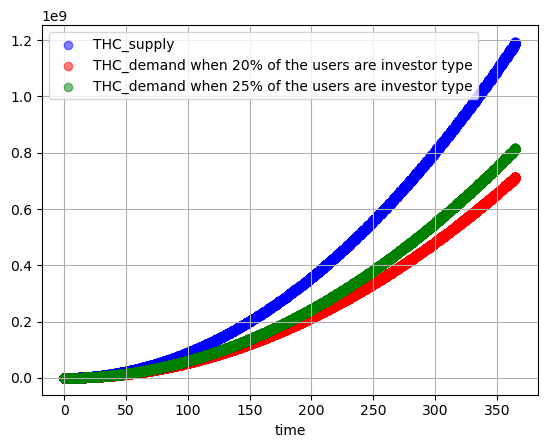

In [20]:
import matplotlib.pyplot as plt
fig_df = df.query('investor_rate == 0.2')
fig_df_1 = df.query('investor_rate == 0.25')
x=fig_df.days
y1=fig_df.THC_supply
y2=fig_df.THC_demand
y3 = fig_df_1.THC_demand

plt.scatter(x, y1, c="b", alpha=0.5, label="THC_supply")
plt.scatter(x, y2, c="r", alpha=0.5, label="THC_demand when 20% of the users are investor type")
plt.scatter(x, y3, c="g", alpha=0.5, label="THC_demand when 25% of the users are investor type")

plt.xlabel("time")
#plt.ylabel("")
plt.legend(loc='upper left')
plt.grid()
plt.show()

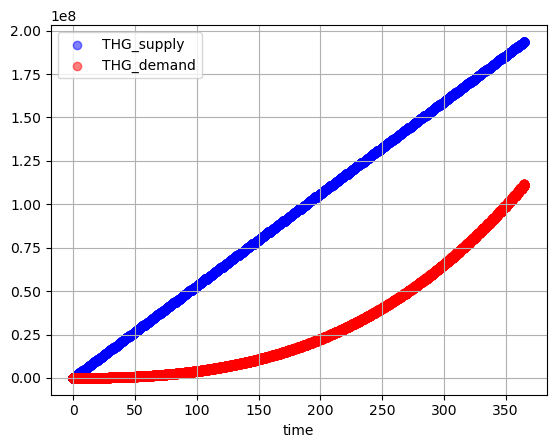

In [267]:
import matplotlib.pyplot as plt
fig_df = df.query('THC_deflation == 0')
x=fig_df.days
y1=fig_df.THG_supply
y2=fig_df.THG_demand

plt.scatter(x, y1, c="b", alpha=0.5, label="THG_supply")
plt.scatter(x, y2, c="r", alpha=0.5, label="THG_demand")
plt.xlabel("time")
#plt.ylabel("")
plt.legend(loc='upper left')
plt.grid()
plt.show()